Transformer (Encoder + decoder ) -> Attention Machenasim

In [ ]:
# Huge Data -> Model -> Pre Trained (Bert) -> Classification (Small Data) -> Finetune

In [ ]:
# Huge Data-> Gpt Model (Pre Trained) -> Classification (Small Data) -> Finetune

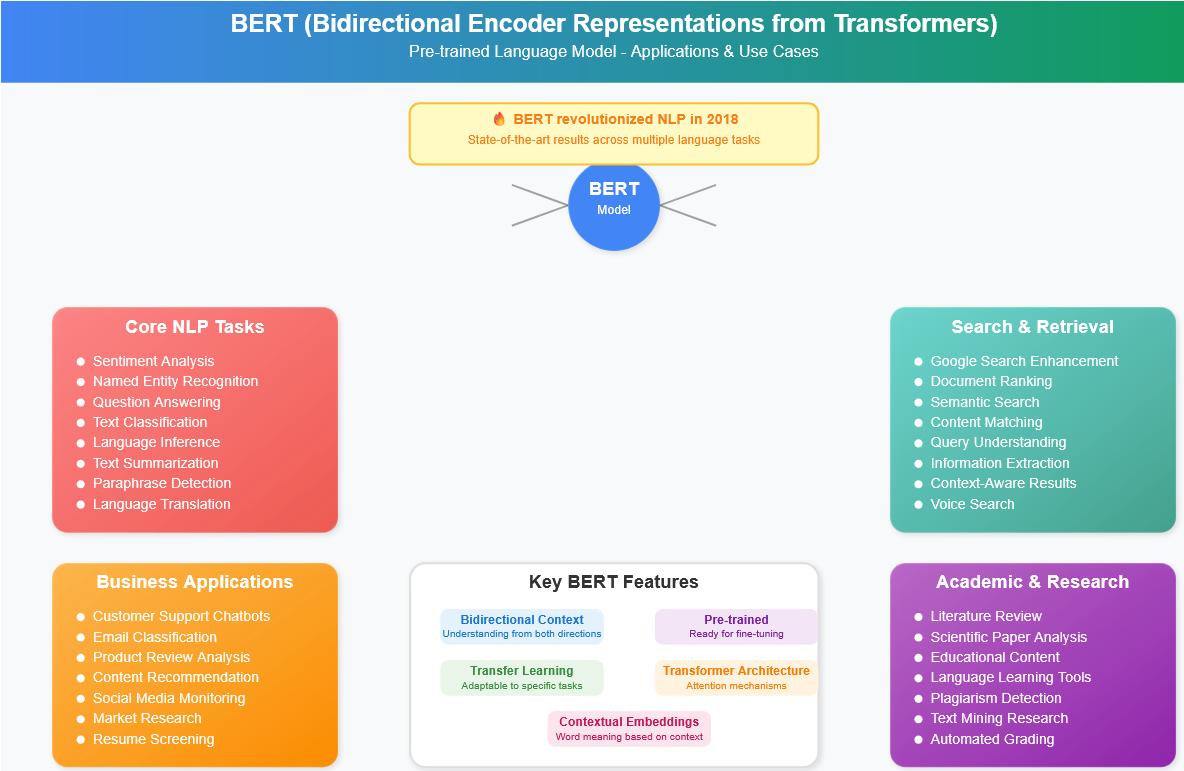
# Hugging Face Transformers Tutorial Notebook

## Introduction to Hugging Face Transformers

Transformers are state-of-the-art models for **Natural Language Processing (NLP)**. Hugging Face provides a library called `transformers` that makes it very easy to use these models.

With Hugging Face, you can:
- Use pre-trained models like **BERT** and **GPT**
- Fine-tune them on your own data
- Perform tasks like **text classification, sentiment analysis, translation, summarization, and text generation**

## Overview of BERT and GPT

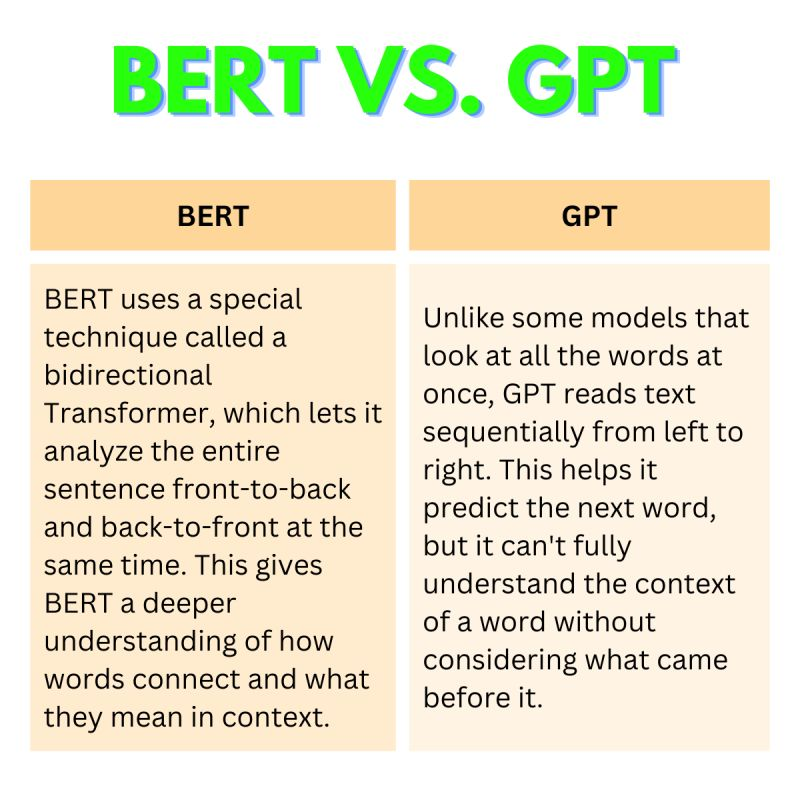

- **BERT (Bidirectional Encoder Representations from Transformers):**
  - Reads text in **both directions** (left-to-right and right-to-left).
  - Great for **understanding** text (classification, question answering, etc.).

- **GPT (Generative Pre-trained Transformer):**
  - Reads text **left-to-right only**.
  - Great for **generating text** (chatbots, story writing, etc.).

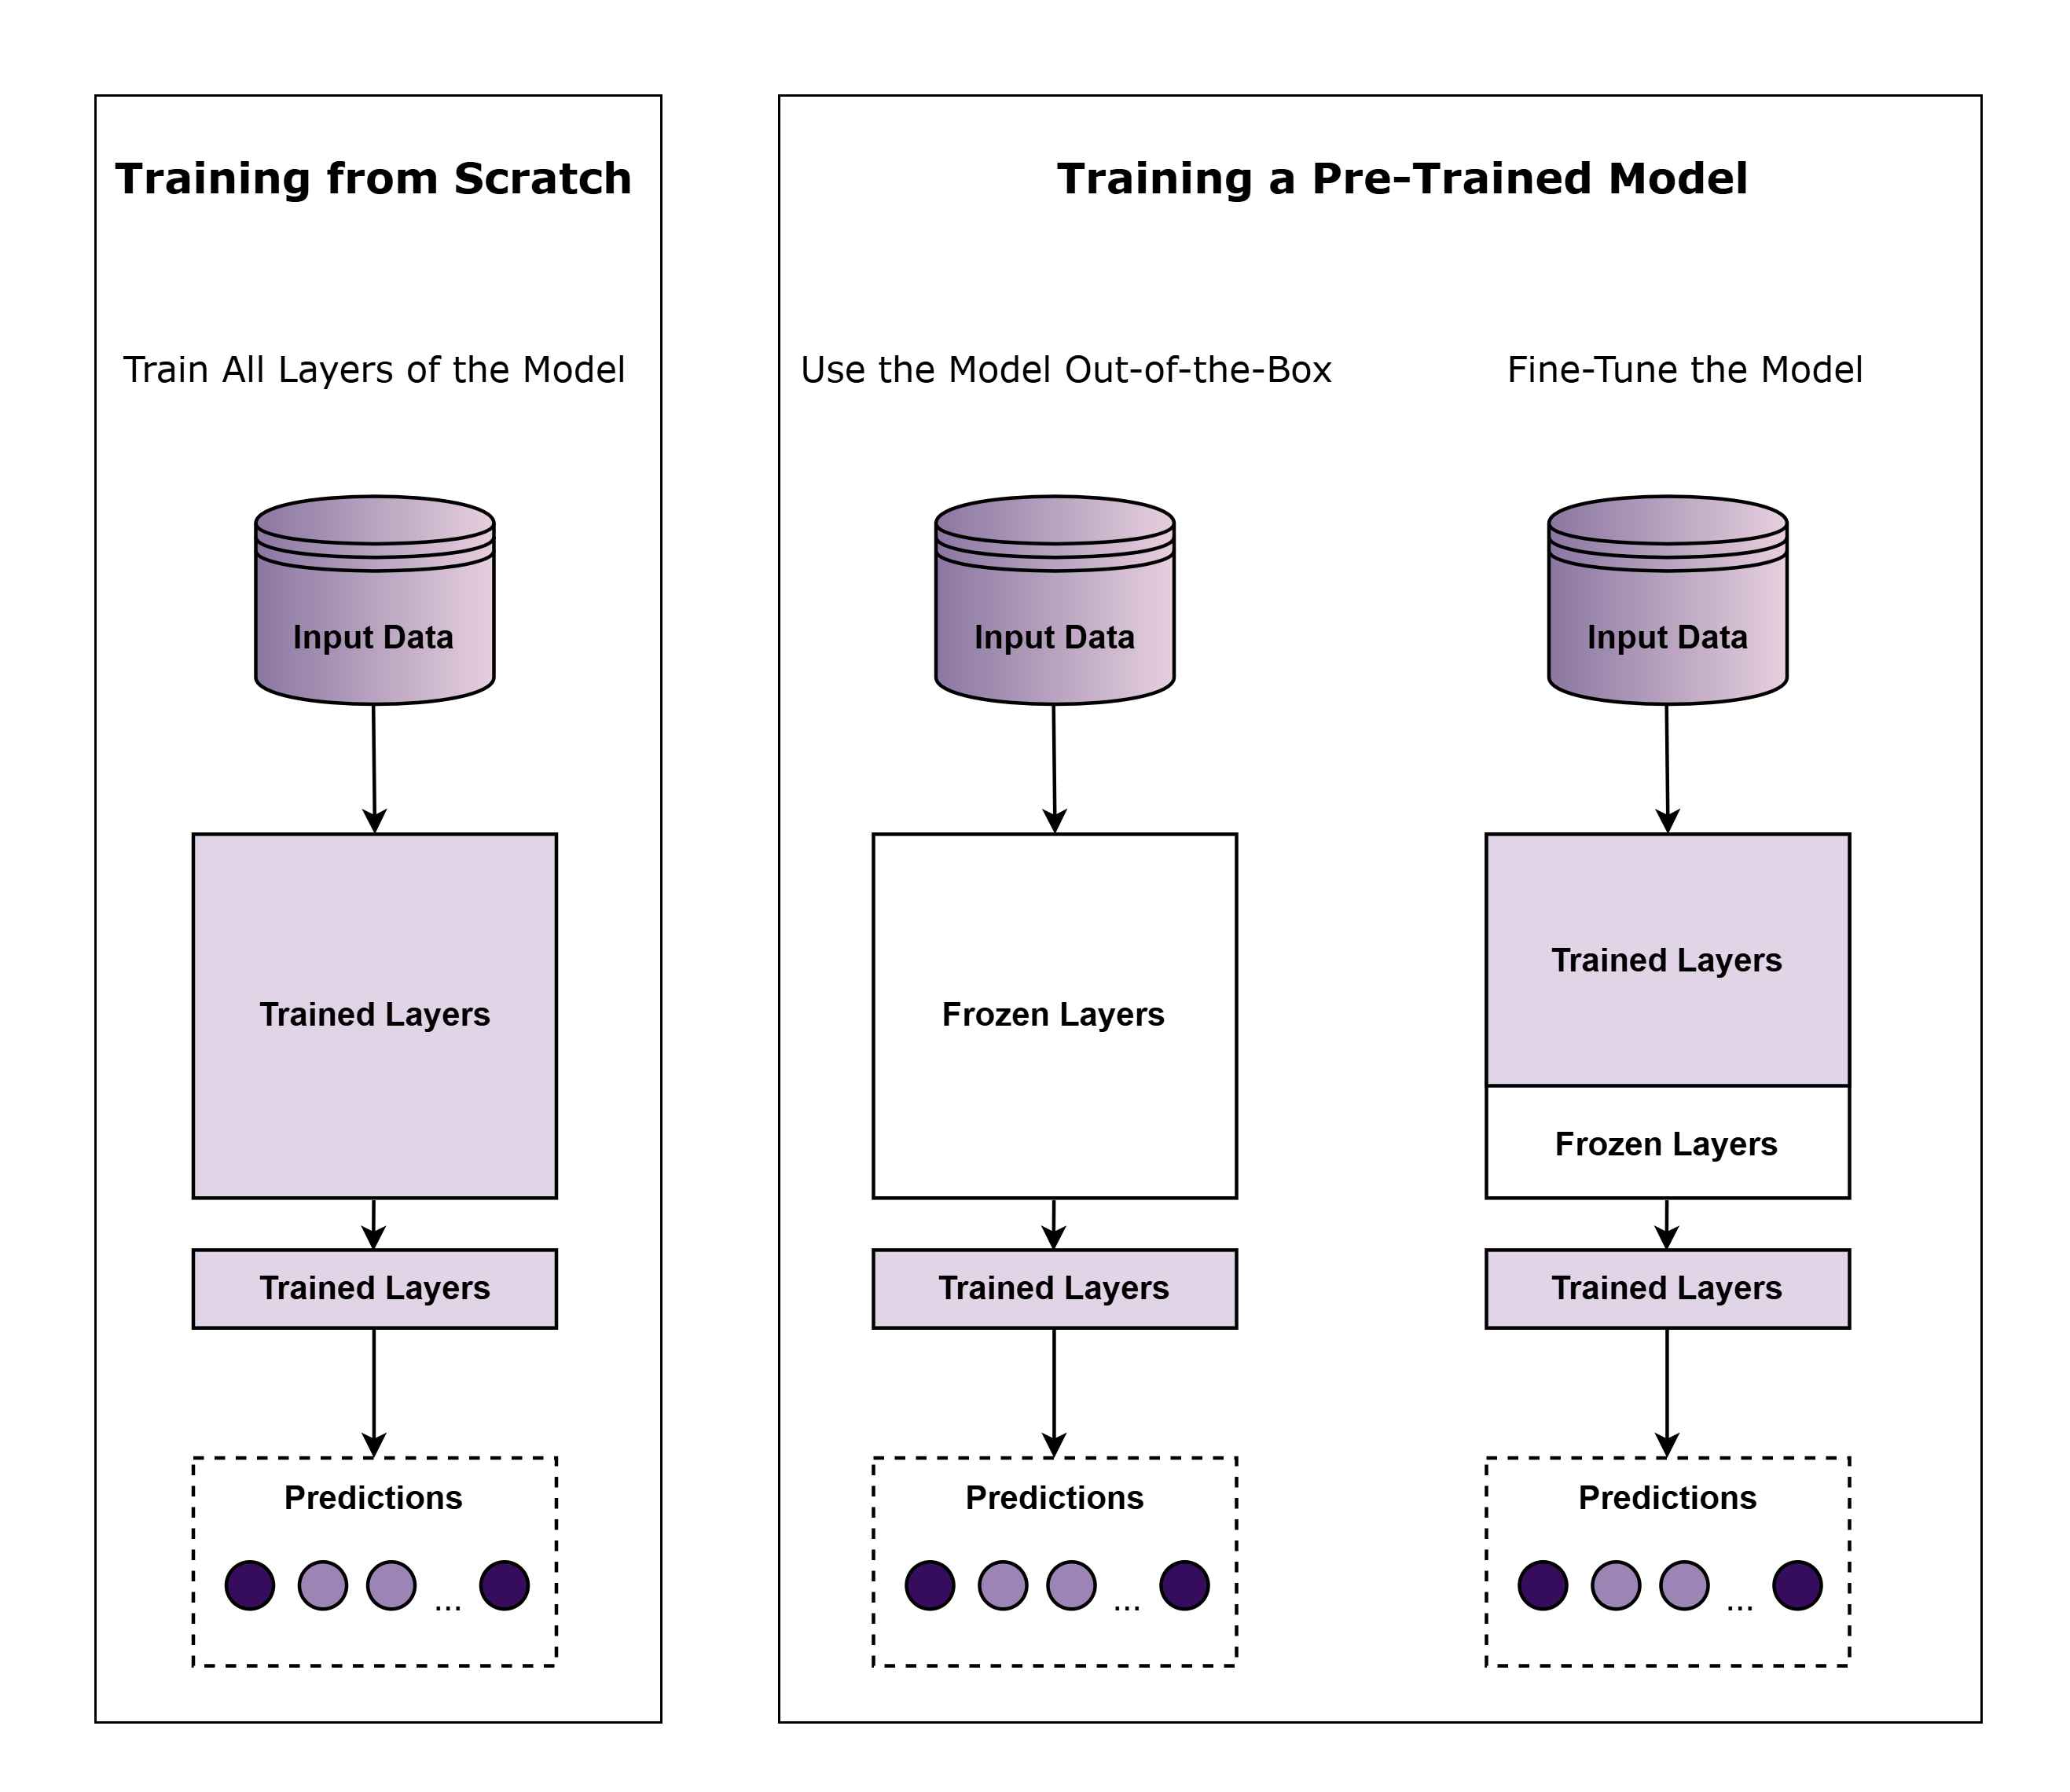

In [ ]:
# Model = combination of weight (Trainable Parameters -> 1B  w1.. w1b  -> Computer Power , Resource , Time , Multiple Gpu)

In [ ]:
# 1b -> w1...w1b (Frozen) + Adapter(500M) -> One technique
# 1b -> 800M (frozen)+ 200M (Trainable parameters) ->2nd technique
# Peft (Parameter Efficient Fine Tuning) + LoRA (Low Rank Adaption)

## Understanding Pre-trained Models and Transfer Learning

- Pre-trained models are trained on massive datasets (Wikipedia, Books, etc.).
- Instead of training from scratch, we **fine-tune** these models on smaller datasets.
- This saves time and resources while giving excellent performance.

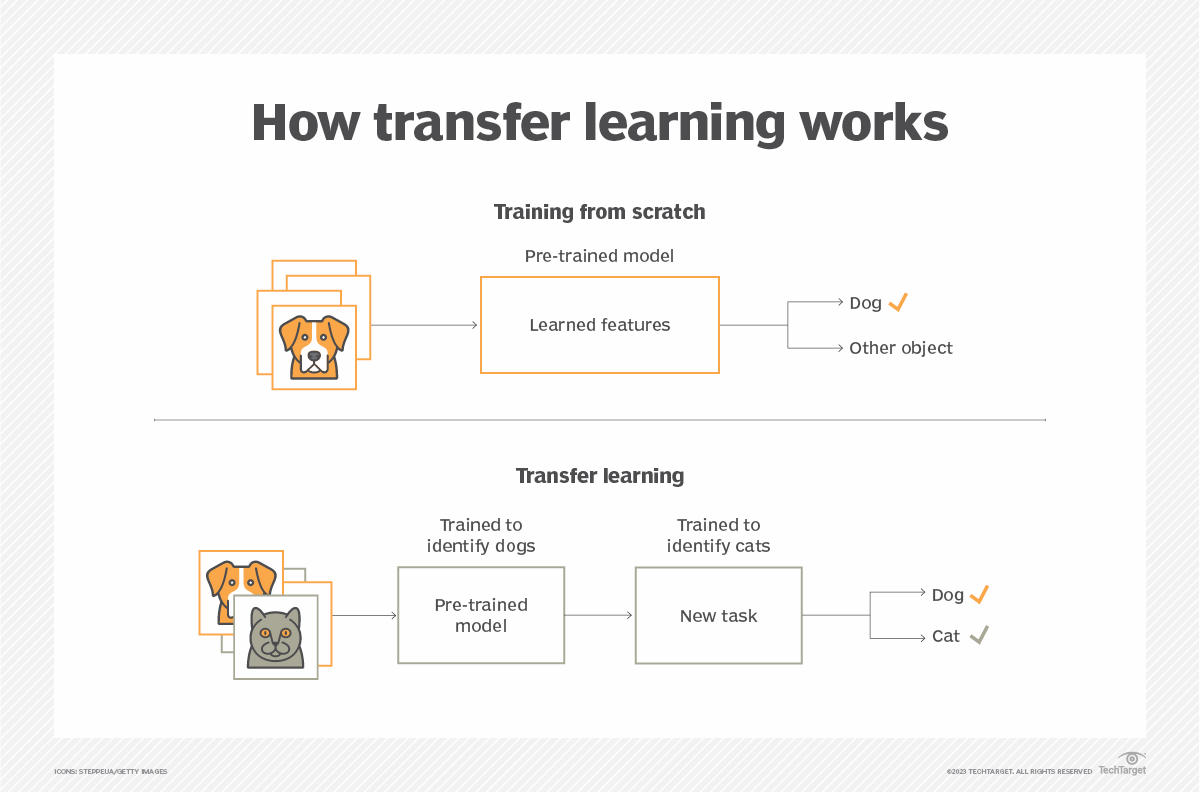

In [ ]:
!pip install transformers datasets torch

## Fine-tuning BERT for Text Classification


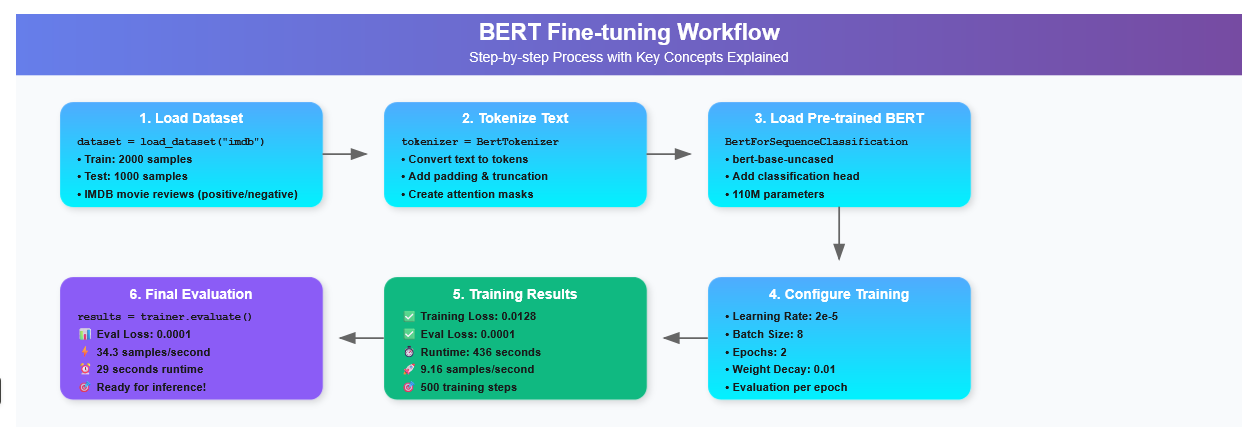
We will use a **small dataset** to train BERT for **sentiment analysis** (positive/negative text classification).

In [ ]:
# Padding : Sentence1 5+1+1 , Sentence2 6+1 Sentence3 7 -> Tokenzation -> Number

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch

In [ ]:
dataset = load_dataset("imdb", split={"train": "train[:2000]", "test": "test[:1000]"})

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# # bert model -> Tokenizer

# 3000 -> Tokentizer -> Tokenize

# 3000 -> 1->tokenize(train[0]['text'])->tokenize [input_ids,attention_mask]

input_id,attention_mask,labels  (3000*3)

In [ ]:
# dataset ->

# text  | labels
# s1    | 0/1
# s2     |0/1

# s1-> tokenize -> input_ids , attention_mask (2 parts)
# labels->label (rename)

# Finetune:
# # 1. Dataset -> convert -> Finetune Format


# input_ids, attention_mask,label -> 3000*3 (pytorch Tensor) -> Trainer(...)

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.rename_column("label", "labels")
dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

### 🔹 Why do we need Tokenization and Formatting?

Transformers like BERT cannot read raw text directly — they only understand **numbers (token IDs)**.  
So before training, we must **tokenize** the text data and prepare it in the correct format.

- `BertTokenizer.from_pretrained("bert-base-uncased")`  
  Loads the same tokenizer that was used when BERT was trained.

- `tokenizer(batch["text"], padding=True, truncation=True)`  
  Converts each sentence into token IDs, adds padding so all sequences are the same length,  
  and truncates if text is too long.

- `dataset.map(tokenize, batched=True)`  
  Applies tokenization to the whole dataset in batches.

- `dataset.rename_column("label", "labels")`  
  Trainer expects the target column to be named **`labels`** (not `label`).

- `dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])`  
  Converts the dataset into **PyTorch tensors** so it can be used directly for training.

👉 In short: This block **turns raw text into BERT-readable numerical tensors** and makes sure the dataset is ready for training with Hugging Face’s `Trainer`.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Vanashing Gradient -> Back Propagation ... (weight) ->Poor Training
# Explodation Gradient -> Back Progration ....(weight) -> Model Unstable
# # time is money

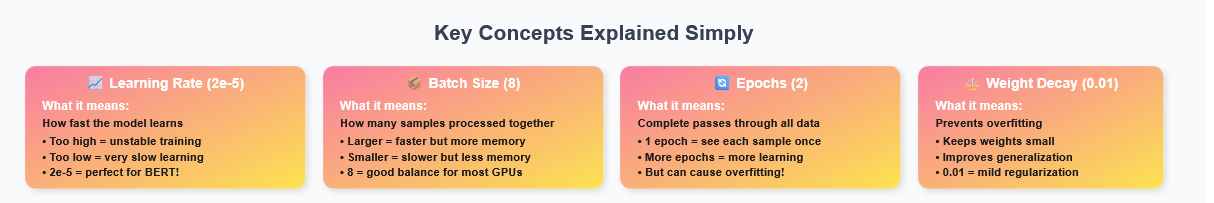

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    report_to="none", # Disable wandb logging,
    push_to_hub="true"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
)

In [ ]:
# 1st Epoch -> 2000 data process (Train)-> Model Weight update -> 1000 (Validation)->
# 2nd Epoch -> 2000 ....                       .....      -> 1000 .....

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.000219
2,0.012900,0.000138


TrainOutput(global_step=500, training_loss=0.012854286193847656, metrics={'train_runtime': 436.6725, 'train_samples_per_second': 9.16, 'train_steps_per_second': 1.145, 'total_flos': 1052444221440000.0, 'train_loss': 0.012854286193847656, 'epoch': 2.0})

In [ ]:
results = trainer.evaluate()
print(results)

NameError: name 'trainer' is not defined

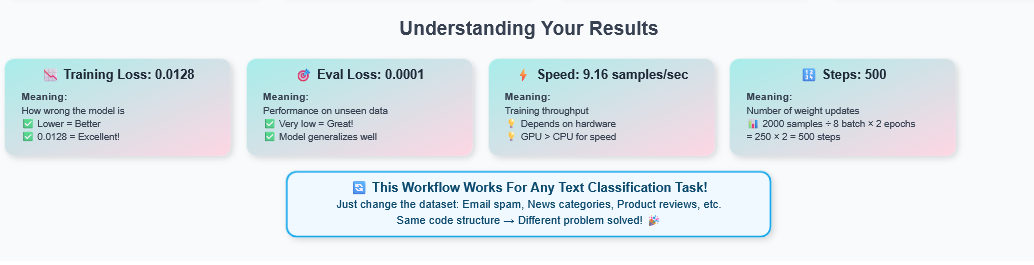

## Fine-tuning GPT for Text Generation

In [ ]:
from transformers import pipeline

generator = pipeline("text-generation", model="gpt2")

output = generator("Once upon a time in Dhaka,", max_length=50, num_return_sequences=1)
print(output[0]['generated_text'])

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Once upon a time in Dhaka, a number of people in the city were killed by a mob.

"There are no security guards here. But there's no one here to help us. We were trying to help. We were trying to help anyone who was injured."

On Saturday morning, the government released a statement that said the "Islamic State" had "destroyed hundreds of houses and destroyed the entire city. The Islamic State has destroyed many villages and cities, and destroyed many churches, mosques and schools".

The statement added that the "Islamic State has destroyed many houses and destroyed the entire city".

"It has also destroyed many houses, mosques and schools in Dhaka," the statement said, adding that the "Islamic State has also destroyed many villages and cities, and destroyed many churches, mosques and schools."

"This is a terrible and brutal attack," the statement continued.

A total of three people were killed by the Islamic State in the city of Dhaka on Friday.

The city's Mayor, Zaneer Mohammad, sai

## Adjusting Hyperparameters
- `learning_rate`: Controls how fast the model learns.
- `batch_size`: Number of examples per training step.
- `num_train_epochs`: Number of times the model sees the full dataset.

## Using Pre-trained Hugging Face Models for NLP

In [ ]:
classifier = pipeline("sentiment-analysis")
print(classifier("I love Hugging Face!"))

translator = pipeline("translation_en_to_fr")
print(translator("Hello, how are you?"))

summarizer = pipeline("summarization")
print(summarizer("Artificial intelligence is a field of computer science that focuses on creating intelligent machines..."))

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
No model was supplied, defaulted to google-t5/t5-base and revision a9723ea (https://huggingface.co/google-t5/t5-base).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998641014099121}]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'translation_text': 'Bonjour, comment êtes-vous?'}]


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

Device set to use cuda:0
Your max_length is set to 142, but your input_length is only 17. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=8)


[{'summary_text': ' Artificial intelligence is a field of computer science that focuses on creating intelligent machines . Artificial intelligence aims to create intelligent machines that can be programmed to be intelligent . Artificial Intelligence is a form of machine intelligence that aims to be more intelligent than other forms of intelligence in the future . Artificial artificial intelligence is now being developed in the form of artificial intelligence .'}]


In [ ]:
# To see the model architecture and layers:
print(model)

# To see the state dictionary (which contains the weights and biases):
# Note: This can be very verbose for larger models
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e